In [4]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wider table display so columns don't wrap
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)

# Path to CSV (relative to this notebook inside /notebooks/)
DATA_PATH = "../data/raw/telco_churn.csv"

# Sanity checks
assert os.path.exists(DATA_PATH), f"CSV not found: {os.path.abspath(DATA_PATH)}"
print("OK: imports loaded and CSV path exists")
print("Python exe:", sys.executable)
print("CWD:", os.getcwd())

OK: imports loaded and CSV path exists
Python exe: C:\Users\amobi\churn-prediction\.venv\Scripts\python.exe
CWD: C:\Users\amobi\churn-prediction\notebooks


In [5]:
# --- Load the CSV ---
df = pd.read_csv(DATA_PATH)

# Normalise column names (trim accidental spaces)
df.columns = [c.strip() for c in df.columns]

# --- First look ---
print("Shape:", df.shape)             # (rows, cols)
print("\nColumns (first 12):", df.columns[:12].tolist())

display(df.head(5))                   # peek at first few rows

print("\nDtypes summary:")
display(df.dtypes)

print("\nMissing values (top 10):")
na = df.isna().sum().sort_values(ascending=False)
display(na.head(10))

Shape: (7043, 21)

Columns (first 12): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Dtypes summary:


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Missing values (top 10):


customerID         0
gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
dtype: int64

In [6]:
import numpy as np

# --- 1) Identify and encode target ---
TARGET = next(c for c in df.columns if c.lower() == "churn")

# Many Telco CSVs store Churn as "Yes"/"No". Normalize -> {1,0}
df[TARGET] = (
    df[TARGET]
    .astype(str).str.strip().str.title()        # handle stray spaces/case
    .map({"Yes": 1, "No": 0})
)
# Guard: if any values didn't map, show them
unmapped = df[TARGET].isna().sum()
print(f"Unmapped target values after mapping: {unmapped}")
if unmapped:
    display(df[df[TARGET].isna()][[TARGET]].head())

# --- 2) Coerce TotalCharges to numeric (known gotcha in this dataset) ---
if "TotalCharges" in df.columns:
    # Before: count NAs; also many rows have blank strings " " which aren't NaN yet
    before_na = df["TotalCharges"].isna().sum()
    blanks = (df["TotalCharges"].astype(str).str.strip() == "").sum()

    # Replace blank strings with NaN, then coerce to float
    df["TotalCharges"] = (
        pd.to_numeric(
            df["TotalCharges"].astype(str).str.strip().replace({"": np.nan}),
            errors="coerce"
        )
    )
    after_na = df["TotalCharges"].isna().sum()
    print(f"TotalCharges NaNs before→after coercion: {before_na} (+{blanks} blanks) → {after_na}")
    print("TotalCharges dtype now:", df["TotalCharges"].dtype)

# --- 3) Quick sanity on class balance ---
vc = df[TARGET].value_counts(dropna=False).sort_index()
churn_rate = vc.get(1, 0) / vc.sum()
print("\nClass counts (0=no, 1=yes):")
print(vc.to_string())
print(f"\nEstimated churn rate: {churn_rate:.3f} ({churn_rate*100:.1f}%)")

Unmapped target values after mapping: 0
TotalCharges NaNs before→after coercion: 0 (+11 blanks) → 11
TotalCharges dtype now: float64

Class counts (0=no, 1=yes):
Churn
0    5174
1    1869

Estimated churn rate: 0.265 (26.5%)


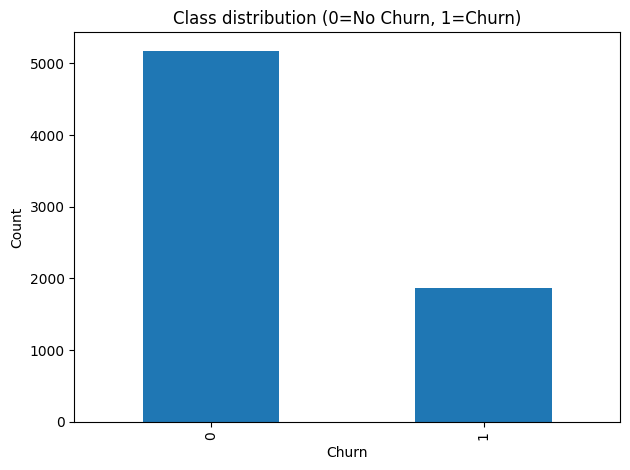

Saved: C:\Users\amobi\churn-prediction\reports\figures\class_distribution.png


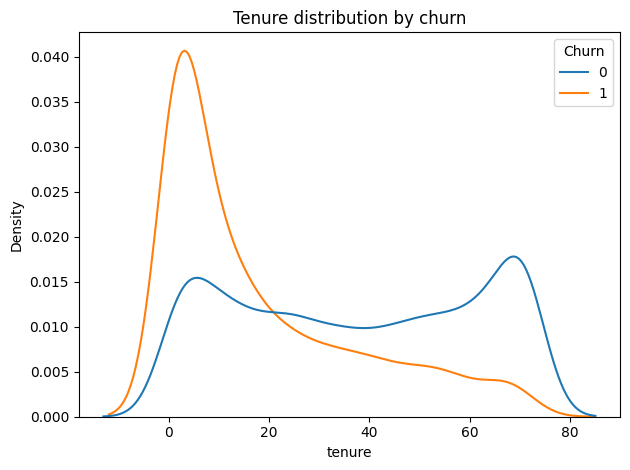

Saved: C:\Users\amobi\churn-prediction\reports\figures\tenure_by_churn.png


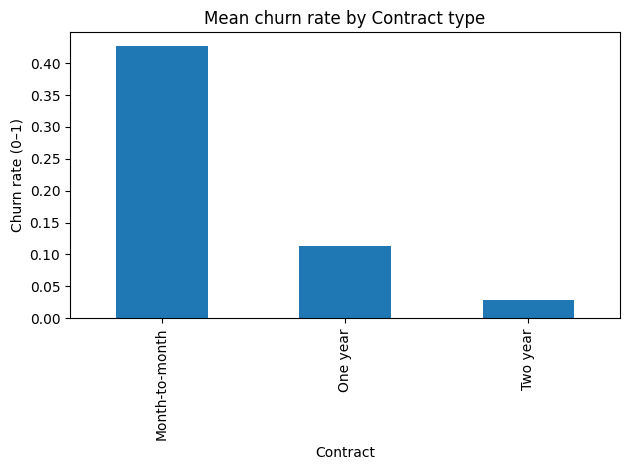

Saved: C:\Users\amobi\churn-prediction\reports\figures\churn_by_contract.png


In [7]:
# Ensure figure folder exists (from /notebooks path this climbs one level)
import os
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# 1) Class distribution (0=no churn, 1=churn)
ax = df["Churn"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Class distribution (0=No Churn, 1=Churn)")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
fig_path1 = f"{FIG_DIR}/class_distribution.png"
plt.tight_layout(); plt.savefig(fig_path1, dpi=150); plt.show()
print("Saved:", os.path.abspath(fig_path1))

# 2) Tenure distribution by churn (if 'tenure' exists)
if "tenure" in df.columns:
    plt.figure()
    sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False)
    plt.title("Tenure distribution by churn")
    plt.tight_layout()
    fig_path2 = f"{FIG_DIR}/tenure_by_churn.png"
    plt.savefig(fig_path2, dpi=150); plt.show()
    print("Saved:", os.path.abspath(fig_path2))
else:
    print("Skipped tenure plot: 'tenure' not found")

# 3) Churn rate by Contract type (if 'Contract' exists)
if "Contract" in df.columns:
    plt.figure()
    (df.groupby("Contract")["Churn"].mean()
       .sort_values(ascending=False)
       .plot(kind="bar"))
    plt.title("Mean churn rate by Contract type")
    plt.ylabel("Churn rate (0–1)")
    plt.tight_layout()
    fig_path3 = f"{FIG_DIR}/churn_by_contract.png"
    plt.savefig(fig_path3, dpi=150); plt.show()
    print("Saved:", os.path.abspath(fig_path3))
else:
    print("Skipped contract plot: 'Contract' not found")

## Project Questions (v1)
- What is the baseline churn rate and class imbalance? *(Observed: ~26.5% churners.)*
- Which features are most predictive of churn (e.g., tenure, contract type, charges)?
- Are there data quality issues (e.g., `TotalCharges` blanks) that need imputing?
- What baseline model should we use (logistic vs tree), and which metric matters most (ROC AUC, recall for churn class)?
- How do we avoid leakage and overfitting (fit all transforms inside a pipeline; stratified split; cross-validation)?

## Initial Observations (from quick EDA)
- **Imbalance:** Churners are the minority (~26.5%) → accuracy alone is misleading.
- **Tenure:** Churners skew to **lower tenure** (new customers leave earlier).
- **Contract:** **Month-to-month** has the highest churn rate; **Two year** the lowest (expected).
- **Caution:** Tenure and contract are correlated; don’t over-interpret causality from these plots.
